In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
path = "../input/archie-comics-multi-class/Multi-class/"

In [3]:
main_dir=os.listdir(path)

In [4]:
file_count = sum(len(files) for _, _, files in os.walk(path))
print(file_count)

6462


In [5]:
samples_per_class = []
classes = []

for each in main_dir:
    currentFolder = path + each
    count = sum(len(files) for _, _, files in os.walk(currentFolder))
    samples_per_class.append(count)
    classes.append(each)
    
print(samples_per_class)
print(classes)
num_classes = len(samples_per_class)
print(num_classes)
min_samples = min(samples_per_class)
print(min_samples)

[41, 71, 146, 85, 550, 962, 157, 67, 259, 34, 46, 33, 151, 109, 46, 679, 64, 121, 1284, 699, 39, 197, 622]
['Kleats', 'Midge', 'Dilton', 'Pop Tate', 'Reggie', 'Jughead', 'Grundy', 'Ethel', 'Weatherbee', 'Harry Clayton', 'Smithers', 'Svenson', 'Moose', 'Chuck', 'Nancy', 'Veronica', 'Flutesnoot', 'Fred Andrews', 'Archie', 'Betty', 'Beazley', 'Hiram Lodge', 'Others']
23
33


In [6]:
index_classes_dict = {k: v for v, k in enumerate(classes)}

In [7]:
index_classes_dict

{'Kleats': 0,
 'Midge': 1,
 'Dilton': 2,
 'Pop Tate': 3,
 'Reggie': 4,
 'Jughead': 5,
 'Grundy': 6,
 'Ethel': 7,
 'Weatherbee': 8,
 'Harry Clayton': 9,
 'Smithers': 10,
 'Svenson': 11,
 'Moose': 12,
 'Chuck': 13,
 'Nancy': 14,
 'Veronica': 15,
 'Flutesnoot': 16,
 'Fred Andrews': 17,
 'Archie': 18,
 'Betty': 19,
 'Beazley': 20,
 'Hiram Lodge': 21,
 'Others': 22}

In [8]:
index_classes_list = list(index_classes_dict.values())

In [9]:
inv_index_classes_dict = {v: k for k, v in index_classes_dict.items()}

In [10]:
inv_index_classes_dict

{0: 'Kleats',
 1: 'Midge',
 2: 'Dilton',
 3: 'Pop Tate',
 4: 'Reggie',
 5: 'Jughead',
 6: 'Grundy',
 7: 'Ethel',
 8: 'Weatherbee',
 9: 'Harry Clayton',
 10: 'Smithers',
 11: 'Svenson',
 12: 'Moose',
 13: 'Chuck',
 14: 'Nancy',
 15: 'Veronica',
 16: 'Flutesnoot',
 17: 'Fred Andrews',
 18: 'Archie',
 19: 'Betty',
 20: 'Beazley',
 21: 'Hiram Lodge',
 22: 'Others'}

In [11]:
inv_index_classes_list = list(inv_index_classes_dict.values())

In [12]:
batch_size = 8

I had made a couple of mistakes when I first ran this.

Mistake No. 1: I had not passed the class_names below, which led to Keras making its own class names list, which did _not_ match the list I made above, meaning that all the Archie images were being labelled as Hiram Lodge in the confusion matrices..._Why_ Archie appears as 18 on the list I make and 21 in the list TF makes is beyond me...it should be the 1st I feel, but isn't...

Mistake No. 2: Based on things I read online, I put shuffle = True for the training and False for the validation set, to preserve label order during validation or something. Bad mistake. This leaks data - the training set gets 80% of all the samples randomly chosen, while the validation only gets the bottom 20% of samples chosen alphanumerically - so essentially only Veronica, Weatherbee, etc...No wonder it got such a high validation true positive rate on Veronica, given that it would have seen a majority of the images already during training...

In [13]:
train = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,
        validation_split=0.2,
        subset="training",
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(256, 256),
    )

Found 6462 files belonging to 23 classes.
Using 5170 files for training.


2022-04-25 10:11:26.429185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 10:11:26.512918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 10:11:26.513695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 10:11:26.516099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
valid = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=classes,
        validation_split=0.2,
        subset="validation",
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(256, 256),
    )

Found 6462 files belonging to 23 classes.
Using 1292 files for validation.


In [15]:
stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=5,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

In [16]:
base_model = tf.keras.applications.ResNet50(weights=None, input_shape=(256, 256, 3), classes=num_classes)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
model = tf.keras.Model(inputs, x)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),#from_logits=True),
        metrics=["accuracy"]
    )
 
loss_0, acc_0 = model.evaluate(valid)
print(f"loss {loss_0}, acc {acc_0}")
    

history = model.fit(
        train,
        validation_data=valid,
        epochs=20,
        callbacks=[stopping, checkpoint]
)

model.load_weights("best_model")

loss, acc = model.evaluate(valid)
print(f"final loss {loss}, final acc {acc}")

2022-04-25 10:11:32.570554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-25 10:11:34.257940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


162/162 [==============================] - 17s 52ms/step - loss: 16.3184 - accuracy: 0.0890
loss 16.31842041015625, acc 0.08900928497314453
Epoch 1/20
647/647 [==============================] - 61s 86ms/step - loss: 2.6060 - accuracy: 0.2147 - val_loss: 4.1864 - val_accuracy: 0.1084
Epoch 2/20
647/647 [==============================] - 56s 86ms/step - loss: 2.3136 - accuracy: 0.3095 - val_loss: 3.2374 - val_accuracy: 0.2314
Epoch 3/20
647/647 [==============================] - 56s 87ms/step - loss: 2.0870 - accuracy: 0.3799 - val_loss: 2.3943 - val_accuracy: 0.3398
Epoch 4/20
647/647 [==============================] - 57s 87ms/step - loss: 1.8830 - accuracy: 0.4284 - val_loss: 1.9731 - val_accuracy: 0.4164
Epoch 5/20
647/647 [==============================] - 56s 86ms/step - loss: 1.6879 - accuracy: 0.4824 - val_loss: 2.0900 - val_accuracy: 0.4218
Epoch 6/20
647/647 [==============================] - 57s 88ms/step - loss: 1.4962 - accuracy: 0.5366 - val_loss: 2.2502 - val_accuracy: 0.4

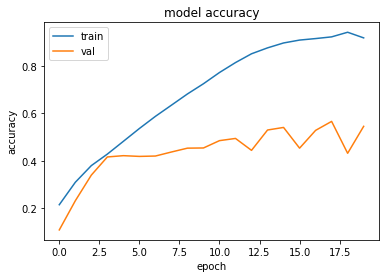

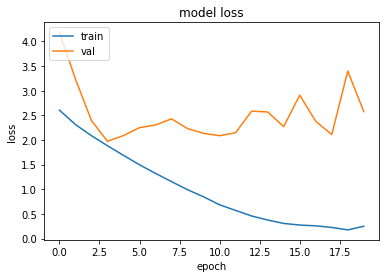

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in valid:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [19]:
names_correct_labels = np.vectorize(inv_index_classes_dict.get)(correct_labels)

In [20]:
names_predicted_labels = np.vectorize(inv_index_classes_dict.get)(predicted_labels)

In [21]:
names_correct_labels[600:620]

array(['Others', 'Archie', 'Dilton', 'Veronica', 'Jughead', 'Others',
       'Archie', 'Betty', 'Archie', 'Betty', 'Veronica', 'Betty',
       'Jughead', 'Archie', 'Archie', 'Weatherbee', 'Archie', 'Jughead',
       'Ethel', 'Betty'], dtype='<U13')

In [22]:
names_predicted_labels[600:620]

array(['Harry Clayton', 'Archie', 'Dilton', 'Veronica', 'Jughead',
       'Others', 'Archie', 'Betty', 'Archie', 'Others', 'Veronica',
       'Betty', 'Jughead', 'Archie', 'Archie', 'Hiram Lodge', 'Archie',
       'Jughead', 'Chuck', 'Archie'], dtype='<U13')

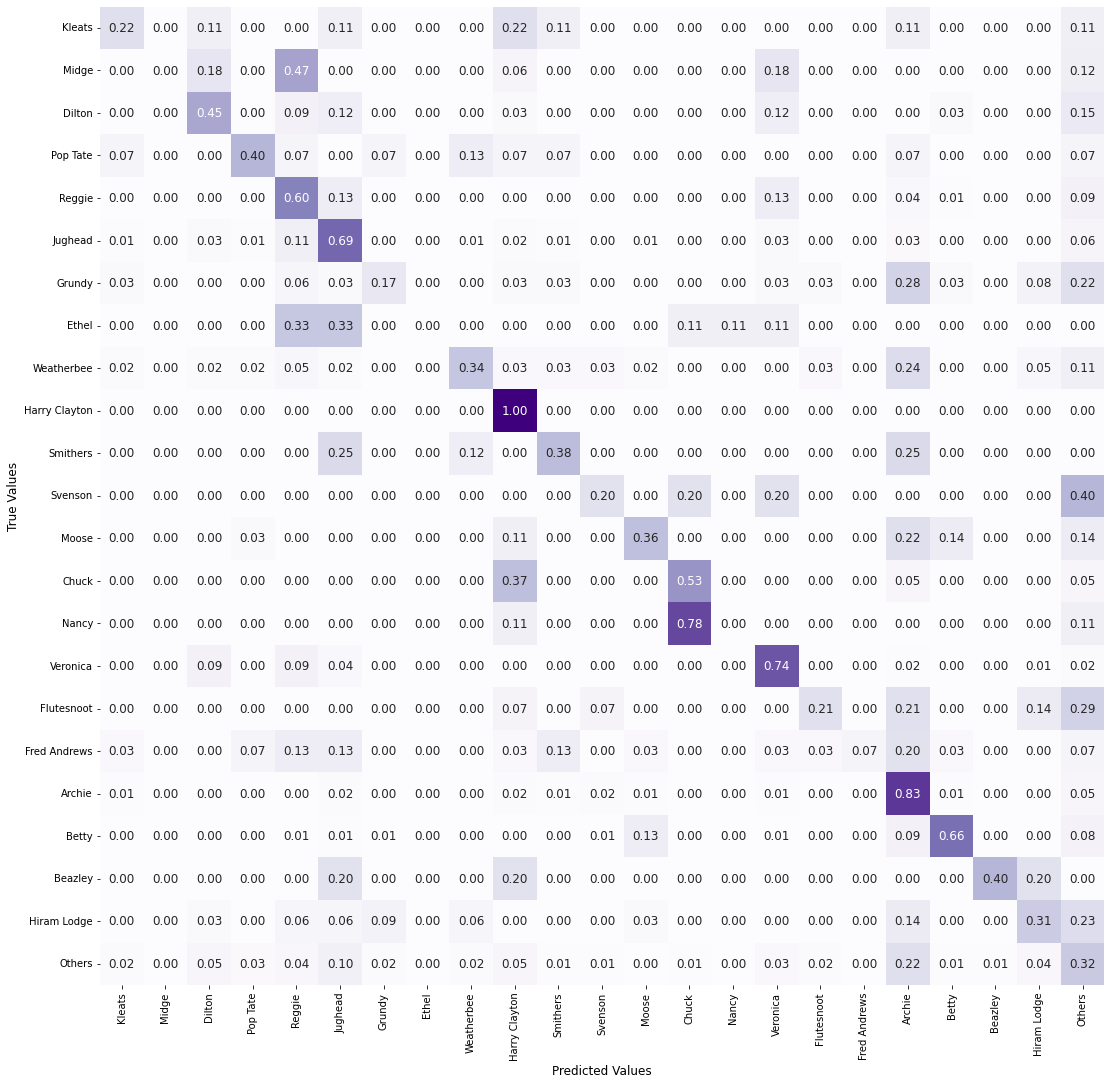

In [23]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list, normalize='true')
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='.2f', 
            xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

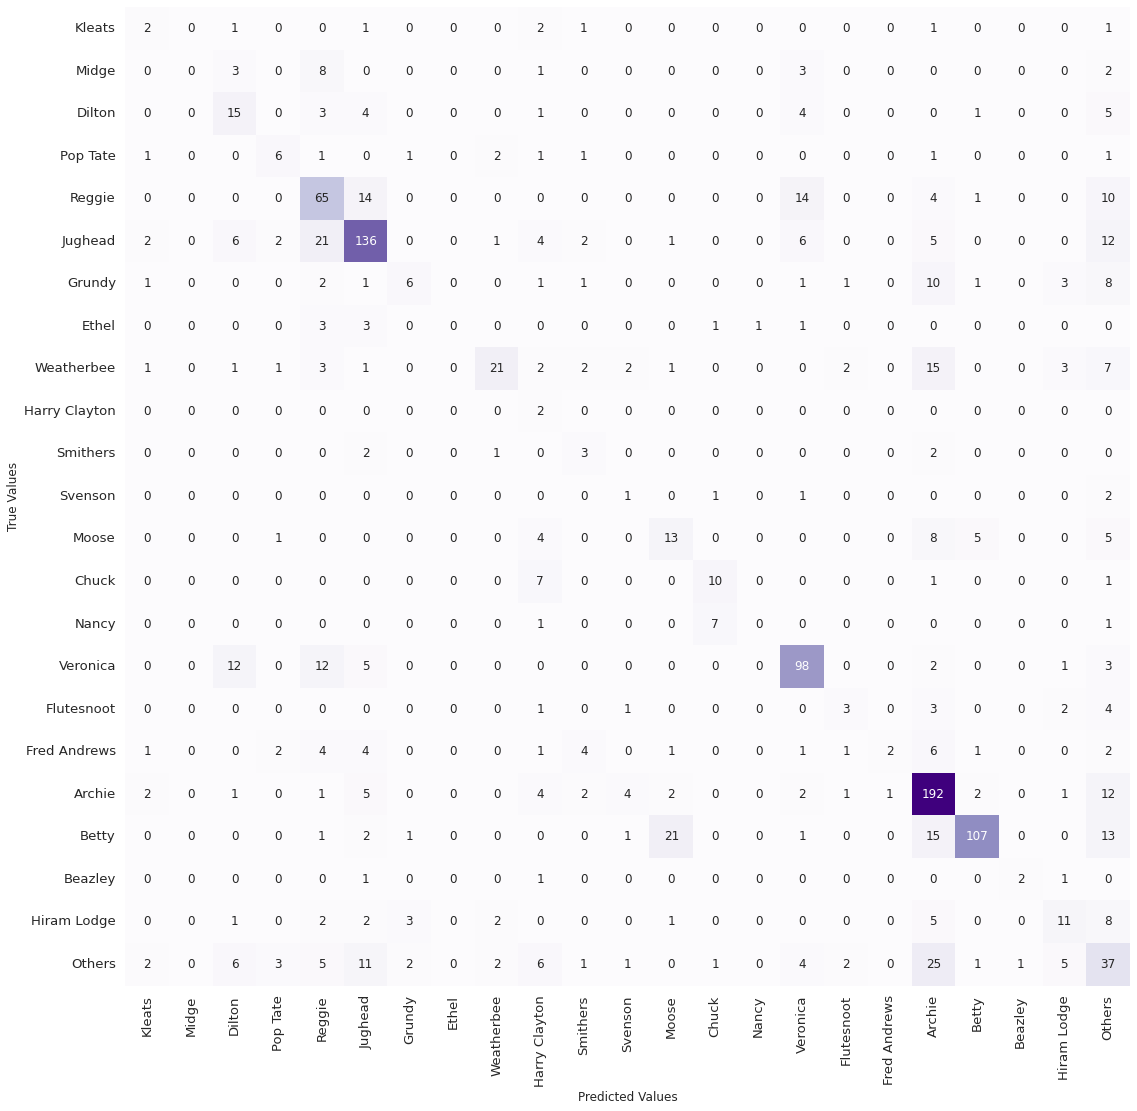

In [24]:
cm = confusion_matrix(correct_labels, predicted_labels, labels=index_classes_list)
fig = plt.figure(figsize = (18,18))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.2) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples', fmt='d',
           xticklabels=inv_index_classes_list, yticklabels=inv_index_classes_list);
ax1.set_ylabel('True Values',fontsize=12)
ax1.set_xlabel('Predicted Values',fontsize=12)
plt.show()

In [25]:
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
# from https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
TPR = TP/(TP+FN)
TPR[18]

0.8275862068965517

In [26]:
df_from_arr = pd.DataFrame(data=[samples_per_class, TPR]).T
df_from_arr.rename(columns={0: "No. of samples", 1: "True positives"}, inplace = True)
df_from_arr.index = classes
df_from_arr["No. of samples"] = df_from_arr["No. of samples"].astype(int)
df_from_arr["True positives"] = df_from_arr["True positives"].round(2)
print(df_from_arr)

               No. of samples  True positives
Kleats                     41            0.22
Midge                      71            0.00
Dilton                    146            0.45
Pop Tate                   85            0.40
Reggie                    550            0.60
Jughead                   962            0.69
Grundy                    157            0.17
Ethel                      67            0.00
Weatherbee                259            0.34
Harry Clayton              34            1.00
Smithers                   46            0.38
Svenson                    33            0.20
Moose                     151            0.36
Chuck                     109            0.53
Nancy                      46            0.00
Veronica                  679            0.74
Flutesnoot                 64            0.21
Fred Andrews              121            0.07
Archie                   1284            0.83
Betty                     699            0.66
Beazley                    39     

<AxesSubplot:xlabel='No. of samples', ylabel='True positives'>

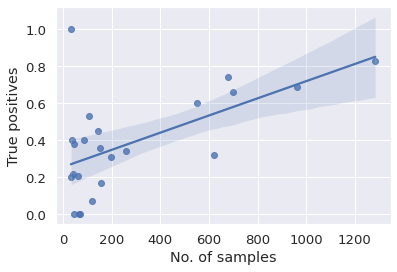

In [27]:
sns.regplot(data=df_from_arr, x="No. of samples", y="True positives")